In [1]:
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torchvision.transforms as T
from skimage.metrics import mean_squared_error, structural_similarity
from skimage.io import imread
from skimage.color import rgb2gray

torch.manual_seed(50)
torch.set_default_dtype(torch.float64)

In [2]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
# print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified


In [3]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-.5, .5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        act_relu=nn.ReLU
        act = nn.LeakyReLU(negative_slope=0.2)
        self.body = nn.Sequential(
        nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2,padding_mode='zeros'),
        act,  
        nn.Conv2d(12, 16, kernel_size=5,padding=5//2, stride=2,padding_mode='zeros'),
        act,
        nn.Conv2d(16, 3, kernel_size=5, padding=5//2, stride=1,padding_mode='zeros'),
        act_relu(),
        nn.Conv2d(3, 3, kernel_size=5, padding=5//2, stride=1,padding_mode='zeros'),
        act_relu(),
        )
        self.fc = nn.Sequential(
            nn.Linear(192, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out=out.view(out.size(0),-1)
        out=self.fc(out)
        return out,x
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [4]:
######### Feed the image to the network and compute gradients #########
img_index = 12
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)


out,org_x = net(gt_data)
y = criterion(out, gt_onehot_label)

dy_dx = torch.autograd.grad(y, net.parameters())

# Extract the gradients and initial parameters
original_dy_dx = [_.numpy() for _ in dy_dx]
param = [i.detach().numpy() for i in net.parameters() if i.requires_grad]

Function to return the details of the layers (e.g., input dimensions, number of filters, padding, stride) for use at runtime

In [5]:
def inspect_model(model,x_dim=32):
    conv_layers = []
    fc_layers = []
    parmeter_index=0   # Hold the index of the parameters of each layer
    input_dim=x_dim
    input_dim_fc=0
    act_fun=''
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            output_dim=int((input_dim+2*module.padding[0]-module.kernel_size[0])/module.stride[0])+1
            layer_details = {
                'param_index':parmeter_index,
                'input_channel': module.in_channels,
                'number_filters': module.out_channels,
                'stride': module.stride[0],
                'padding': module.padding[0],
                'kernel': module.kernel_size[0],
                'input_dim':input_dim,
                'output_dim':output_dim,
                'act_fun':act_fun
            }
            conv_layers.append(layer_details)
            input_dim=output_dim
            input_dim_fc=input_dim**2*module.out_channels
            parmeter_index+=2
        elif isinstance(module, nn.Linear):
            layer_fc_details = {
                'param_index':parmeter_index,
                'input_dim':(input_dim_fc),
                'output_dim':module.out_features
            }
            fc_layers.append(layer_fc_details)
            input_dim_fc=module.out_features
            parmeter_index+=2
        elif isinstance(module, (nn.ReLU, nn.LeakyReLU, nn.Sigmoid, nn.Tanh)):
            act_fun=str(module.__class__).split(".")[-1].split("'")[0]
            conv_layers[-1]['act_fun']=act_fun
    return conv_layers,fc_layers

Function to compute the gradient w.r.t the input of the convolutional layer

In [6]:
def drive_gradient(input_shape,weights,output_gradients,stride,padding):
    weights = torch.tensor(weights, requires_grad=True)
    input_tensor = torch.randn(input_shape, requires_grad=True)
    dL_dY = output_gradients
    
    # dummy forward pass to build the computational graph
    output = F.conv2d(input_tensor, weights, stride=stride, padding=padding)
    output.backward(dL_dY)
    dL_dX= input_tensor.grad
    return dL_dX


Function to reconstruct the input of a convolutional layer using gradient constraints

In [7]:
def construt_input_using_gradients(num_f,num_c,dim_x,output_gradient,weight_gradeint,padding,stride,kernal=5):
    input_matrix=dim_x*dim_x
    pad_dim=dim_x+2*padding
    a=np.array(output_gradient)
    Filters_gradients=np.array(weight_gradeint).reshape(num_f,num_c,kernal,kernal)
    x=[]
    indices=[]
    for n in range(num_c):
        cord_a=[]
        cord_b=[]
        rank=0
        for i in range(num_f):
            for k in range(kernal):
                for l in range(kernal):
                    if(rank==input_matrix):
                        break
                    cord_b.append(Filters_gradients[i][n][k][l])
                    array_gradients=np.zeros(pad_dim**2).reshape(pad_dim,pad_dim)
                    array_gradients[k:k+dim_x:stride,l:l+dim_x:stride]=a[i:i+1]
                    cord_a.append(array_gradients[padding:padding+dim_x,padding:padding+dim_x].reshape(input_matrix))
                    if(n==0):
                        current_rank=np.linalg.matrix_rank(cord_a)
                        if (current_rank==rank):
                            indices.append(i*25+k*5+l)
                            cord_a=cord_a[:-1]
                            cord_b=cord_b[:-1]
                        rank=current_rank
        if n!=0:
            cord_a=np.delete(cord_a,indices,axis=0)
            cord_b=np.delete(cord_b,indices,axis=0)
            cord_a=cord_a[0:input_matrix]
            cord_b=cord_b[0:input_matrix]
        sol=np.linalg.solve(cord_a,cord_b)
        sol2=sol.reshape(dim_x,dim_x)
        x.append(sol2)
    x=np.array(x).reshape(num_c,dim_x,dim_x)
    return x

Function to reconstruct the input of a convolutional layer using weight constraints

In [8]:
def construt_input_using_weights(num_filters,num_c,dim_x,Y,W,pad,stride,kernal=5):
    a=[]
    b=[]
    dim=dim_x**2
    pdim=dim_x+pad
    for n in range(num_filters):
        q=0
        for k in range(0,dim_x,stride):
            v=0
            for l in range(0,dim_x,stride):
                a_row=np.zeros(dim_x**2*num_c)
                for c in range(num_c):
                    x1_=np.zeros((dim_x+2*pad)**2).reshape(dim_x+2*pad,dim_x+2*pad)
                    x1_[k:k+kernal,l:l+kernal]=W[n][c]
                    a_row[c*dim:dim+c*dim]=x1_[pad:pdim,pad:pdim].reshape(dim)
                a.append(a_row)
                b.append(Y[n][q][v])
                v+=1
            q+=1
    sol=np.linalg.solve(a[:dim_x**2*num_c],b[:dim_x**2*num_c]).reshape(num_c,dim_x,dim_x)
    return sol

Reconstruct the input and the gradient w.r.t the input of the first fully connected layer

In [9]:
cnn_layers,fc_layers=inspect_model(net)
FC=fc_layers[0]
in_dim=FC['input_dim']
out_dim=FC['output_dim']
w_index=FC['param_index']
b_index=w_index+1
#Compute The gradient w.r.t input to FC sum ( bias * weight)

FC_input_gradient=np.zeros(in_dim)
FC_input_values=np.zeros(in_dim)
for i in range(out_dim):
    for n in range(in_dim):
      FC_input_gradient[n]+= original_dy_dx[b_index][i]*param[w_index][i][n]
      
# Compute the values of the input of FC ( weigh/bias)

for n in range(in_dim):
  for k in range(out_dim):
    if original_dy_dx[b_index][k]!=0:
      FC_input_values[n]= original_dy_dx[w_index][k][n]/original_dy_dx[b_index][k]

Computed_gradients= torch.tensor(FC_input_gradient.copy())
Computed_values=FC_input_values.copy()
    

Reconstruct the input and compute the gradient with respect to the input of the convolutional layers:<br>
For each layer :<br>
    1- Propagating the precomputed gradient of the subsequent layer through the activation function<br>
    2- Constructing the input based on gradient constraints<br>
    3-Computing the gradient with respect to the input<br>

In [10]:
for n in range(len(cnn_layers)-1,-1,-1):
  # Extract the layer setting 
  cnn=cnn_layers[n]
  num_filters=cnn['number_filters']
  num_c=cnn['input_channel']
  dim_x=cnn['input_dim']
  w_index=cnn['param_index']
  weight_gradient=original_dy_dx[w_index]
  output_gradient= Computed_gradients
  padding=cnn['padding']
  stride=cnn['stride']
  out_dim=cnn['output_dim']
  act_fun=cnn['act_fun']
  # Propagate the gradient through the activation Funciton
  Computed_values=Computed_values.reshape(out_dim**2*num_filters)
  output_gradient=output_gradient.reshape(out_dim**2*num_filters)
  output_values=Computed_values.reshape(out_dim**2*num_filters)
  for i in range(out_dim**2*num_filters):
    if(act_fun=='ReLU'):
      if np.round(Computed_values[i],7)<=0:
        output_gradient[i]=0
    elif(act_fun=='LeakyReLU'):
      if np.round(Computed_values[i],7)<0:
        output_gradient[i]=output_gradient[i]*0.2
        output_values[i]=output_values[i]/0.2
  
  if(n!=0):   # check if reached the first convloution layer        
    output_gradient=output_gradient.clone().detach()
    output_gradient=output_gradient.reshape(num_filters,out_dim,out_dim)

    # construct the output_values of the layer
    x=construt_input_using_gradients(num_filters,num_c,dim_x,output_gradient,weight_gradient,padding,stride)
    # Compute the gradient w.r.t input of the layer
    dL_dX_CNN= drive_gradient(x.shape,param[w_index],output_gradient,stride,padding)

    Computed_gradients= dL_dX_CNN
    Computed_values=x
  else:      # in case of the first convloution layer we construct the input using weight constrains
    Y=output_values.reshape(num_filters,out_dim,out_dim)
    weights = param[w_index] 
    bias=param[w_index+1]
    for i in range(num_filters):
        Y[i]=Y[i]-bias[i]
    sol= construt_input_using_weights(num_filters,num_c,dim_x,Y,weights,padding,stride)

View Reconstructed Image

(-0.5, 31.5, 31.5, -0.5)

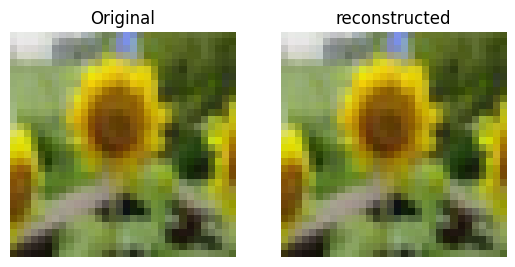

In [11]:
reconstructed_val=torch.tensor(sol).reshape(3,32,32)
oringinal_val=org_x.clone().detach()
oringinal_val=oringinal_val.reshape(3,32,32)
plt.subplot(1, 2,  1)
plt.imshow(tt(oringinal_val))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2,  2)
plt.imshow(tt(reconstructed_val))
plt.title("reconstructed")
plt.axis('off')


In [12]:
#measure the quality of the image

mse=mean_squared_error(np.array(oringinal_val),np.array(reconstructed_val))
print(f'The Error in the construction(MSE): {mse}')

Max=255
PSNR = 20*np.log10(Max)-10*np.log10(mse)
print("PSNR: ",PSNR)

The Error in the construction(MSE): 1.1264123494237117e-18
PSNR:  227.6138295765548
